# BETO Fine-Tuning Acronym Classification


## Enviroment

### Activating the GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Installing the Hugging Face PyTorch Interface for Bert

In [2]:
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install -q transformers=='4.6.1'
#!pip install git+https://github.com/huggingface/transformers #version 4.8

### Importing the modules

In [112]:
#!pip install -q torch==1.8.1

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertForMaskedLM
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
% matplotlib inline

In [114]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

### Specifying CUDA as the device for Torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Data

In [5]:
df = pd.read_csv("train_data_beto_10_amb_lfnorm.csv", delimiter=',')
df.shape

(2232, 5)

In [6]:
df.sample(10)

,Unnamed: 0,short_form,context,long_form,label
549,549,mm,dentro del transoperatorio con una abertura or...,milimetro,1
68,68,mm,"Corporation ) , pasando a continuación un gast...",milimetro,1
1470,1470,h,"el paciente , volvemos a pautar Durogesic® Mat...",microgramo,0
965,965,cm,abdominal demostró una vena porta de calibre a...,centimetro agua,0
271,271,s,zonas sarcomatosas y negativo en zonas epiteli...,segundo,0
422,422,C,fiebre pero a su ingreso la temperatura era de...,peak c,0
170,170,C,lavado se realizó con solución salina isotónic...,centimetro,0
1090,1090,kg,. La anticoagulación fue variable con epoprost...,kilogramo,1
1991,1991,S,en el filete óptico . La inmunohistoquímica fu...,soluble,1
1392,1392,h,de FL . Se instauró NPT y somatostatina 3 mg/1...,hora,1


In [7]:
df = df[['short_form', 'context','long_form', 'label']]

In [8]:
# Adding CLS and SEP tokens at the beginning and end of each LF for BETO
df['sentences'] = df['long_form'].map(lambda x: "[CLS] " + x + " [SEP] ")+df['context'] + ' [SEP]'

In [9]:
df.head()

,short_form,context,long_form,label,sentences
0,GPT,bioquímicos en sangre eran normales salvo la G...,glutamic pyruvic transaminar,1,[CLS] glutamic pyruvic transaminar [SEP] bioqu...
1,GPT,bioquímicos en sangre eran normales salvo la G...,glutamate pyruvatar transaminar,0,[CLS] glutamate pyruvatar transaminar [SEP] bi...
2,C,"la delgadez ( IMC 17 ) , temperatura 37 º < st...",centimetro,1,[CLS] centimetro [SEP] la delgadez ( IMC 17 ) ...
3,C,"la delgadez ( IMC 17 ) , temperatura 37 º < st...",centigrado,0,[CLS] centigrado [SEP] la delgadez ( IMC 17 ) ...
4,C,"la delgadez ( IMC 17 ) , temperatura 37 º < st...",cysteine,0,"[CLS] cysteine [SEP] la delgadez ( IMC 17 ) , ..."


In [10]:
#Creating sentence, label lists and adding Bert tokens
sentences = df.sentences.values

labels = df.label.values

In [11]:
sentences[:3]

array(['[CLS] glutamic pyruvic transaminar [SEP] bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end > 51 , gamma-GT 67 y las proteínas totales que eran [SEP]',
       '[CLS] glutamate pyruvatar transaminar [SEP] bioquímicos en sangre eran normales salvo la GOT 87 , < start > GPT < end > 51 , gamma-GT 67 y las proteínas totales que eran [SEP]',
       '[CLS] centimetro [SEP] la delgadez ( IMC 17 ) , temperatura 37 º < start > C < end > tensión arterial 105/60 , se encontraba consciente y orientada , [SEP]'],
      dtype=object)

### Activating the BETO Tokenizer

In [12]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'glu', '##tam', '##ic', 'py', '##ru', '##vic', 'trans', '##amina', '##r', '[SEP]', 'bio', '##quí', '##micos', 'en', 'sangre', 'eran', 'normales', 'salvo', 'la', '[UNK]', '8', '##7', ',', '<', 'star', '##t', '>', '[UNK]', '<', 'end', '>', '51', ',', 'gamma', '-', '[UNK]', '6', '##7', 'y', 'las', 'proteínas', 'totales', 'que', 'eran', '[SEP]']


### Processing Data

In [13]:
# Set the maximum sequence length.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [14]:
input_ids[0]

array([    4, 20541, 13141,  1060,  8319,  1366, 20140,  1678, 27368,
       30960,     5,  5433,  7384,  6545,  1035,  3244,  2314, 11410,
        4576,  1032,     3,   997,   998,  1019,   983,  5870, 30964,
         981,     3,   983, 17788,   981,  6071,  1019, 25892,  1139,
           3,  1001,   998,  1040,  1085, 14601, 15512,  1041,  2314,
           5,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [15]:
#Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [127]:
#attention_masks[0]

In [16]:
#Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [17]:
#Converting all the data into torch tensors
# Torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [18]:
#Selecting a Batch Size and Creating and Iterator 
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Bert Configuration 

In [22]:
try:
  import transformers
except:
  print("Installing transformers")
  !pip -qq install transformers
  


# Initializing a model from the bero-basestyle configuration
model1 = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels = 2)
model2 = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels = 2)
model3 = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels = 2)

# Accessing the model configuration
configuration1 = model1.config
configuration2 = model2.config
configuration3 = model3.config
print(configuration1)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}



In [23]:
model1.cuda()
model2.cuda()
model3.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Optimizer Grouped Parameters

In [24]:
param_optimizer1 = list(model1.named_parameters())
param_optimizer2 = list(model2.named_parameters())
param_optimizer3 = list(model3.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters1 = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer1 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer1 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer_grouped_parameters2 = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer2 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer2 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer_grouped_parameters3 = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer3 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer3 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

### The Hyperparemeters for the Training Loop

In [25]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 15

optimizer1 = AdamW(optimizer_grouped_parameters1,
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
optimizer2 = AdamW(optimizer_grouped_parameters2,
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
optimizer3 = AdamW(optimizer_grouped_parameters3,
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler1 = get_linear_schedule_with_warmup(optimizer1, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler2 = get_linear_schedule_with_warmup(optimizer2, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler3 = get_linear_schedule_with_warmup(optimizer3, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [26]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# The Training Loop

### Model 1

In [27]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model1.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):

    #print(step,batch)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #print(b_input_ids.shape, b_input_mask.shape, b_labels.shape)
    # Clear out the gradients (by default they accumulate)
    optimizer1.zero_grad()
    # Forward pass
    outputs = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer1.step()

    # Update the learning rate.
    scheduler1.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model1.eval()

  # Tracking variables 
  predictions1_train , true_labels1_train = [], []

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()


    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

    # Store predictions and true labels
    predictions1_train.append(logits)
    true_labels1_train.append(label_ids)

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.6048026184240977


Epoch:   7%|▋         | 1/15 [01:17<18:10, 77.88s/it]

Validation Accuracy: 0.8214285714285714
Train loss: 0.36191575205515303


Epoch:  13%|█▎        | 2/15 [02:36<16:54, 78.00s/it]

Validation Accuracy: 0.84375
Train loss: 0.2948248292955141


Epoch:  20%|██        | 3/15 [03:54<15:37, 78.11s/it]

Validation Accuracy: 0.8392857142857143
Train loss: 0.2609350596155439


Epoch:  27%|██▋       | 4/15 [05:13<14:20, 78.22s/it]

Validation Accuracy: 0.8303571428571429
Train loss: 0.24242864750207416


Epoch:  33%|███▎      | 5/15 [06:31<13:02, 78.29s/it]

Validation Accuracy: 0.8303571428571429
Train loss: 0.21564668464282202


Epoch:  40%|████      | 6/15 [07:49<11:44, 78.31s/it]

Validation Accuracy: 0.8348214285714286
Train loss: 0.2013636738771484


Epoch:  47%|████▋     | 7/15 [09:08<10:26, 78.34s/it]

Validation Accuracy: 0.84375
Train loss: 0.18866074318805384


Epoch:  53%|█████▎    | 8/15 [10:26<09:08, 78.38s/it]

Validation Accuracy: 0.8303571428571429
Train loss: 0.16694440201870978


Epoch:  60%|██████    | 9/15 [11:45<07:50, 78.41s/it]

Validation Accuracy: 0.8348214285714286
Train loss: 0.1537878740992811


Epoch:  67%|██████▋   | 10/15 [13:03<06:32, 78.42s/it]

Validation Accuracy: 0.8214285714285714
Train loss: 0.14623984552565075


Epoch:  73%|███████▎  | 11/15 [14:22<05:13, 78.42s/it]

Validation Accuracy: 0.8125
Train loss: 0.14324368959263203


Epoch:  80%|████████  | 12/15 [15:40<03:55, 78.44s/it]

Validation Accuracy: 0.8125
Train loss: 0.12553704967574467


Epoch:  87%|████████▋ | 13/15 [16:58<02:36, 78.44s/it]

Validation Accuracy: 0.8169642857142857
Train loss: 0.12699374086445286


Epoch:  93%|█████████▎| 14/15 [18:17<01:18, 78.43s/it]

Validation Accuracy: 0.8125
Train loss: 0.11909702306406365


Epoch: 100%|██████████| 15/15 [19:35<00:00, 78.39s/it]

Validation Accuracy: 0.8125


### Model 2

In [137]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model2.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer1.zero_grad()
    # Forward pass
    outputs = model2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer2.step()

    # Update the learning rate.
    scheduler2.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model2.eval()

  # Tracking variables 
  predictions2_train , true_labels2_train = [], []

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

    # Store predictions and true labels
    predictions2_train.append(logits)
    true_labels2_train.append(label_ids)

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.7163306484146724


Epoch:   7%|▋         | 1/15 [01:18<18:19, 78.56s/it]

Validation Accuracy: 0.6428571428571429
Train loss: 0.7041706480677166


Epoch:  13%|█▎        | 2/15 [02:36<16:59, 78.44s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.7133282006733002


Epoch:  20%|██        | 3/15 [03:54<15:39, 78.30s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.7259703902971177


Epoch:  27%|██▋       | 4/15 [05:12<14:20, 78.21s/it]

Validation Accuracy: 0.36607142857142855
Train loss: 0.7760010995562114


Epoch:  33%|███▎      | 5/15 [06:30<13:01, 78.15s/it]

Validation Accuracy: 0.36607142857142855
Train loss: 0.8899488591012501


Epoch:  40%|████      | 6/15 [07:48<11:42, 78.08s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.883700568524618


Epoch:  47%|████▋     | 7/15 [09:06<10:24, 78.06s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.7358877431778681


Epoch:  53%|█████▎    | 8/15 [10:24<09:06, 78.04s/it]

Validation Accuracy: 0.36607142857142855
Train loss: 0.7305229107538859


Epoch:  60%|██████    | 9/15 [11:42<07:48, 78.03s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.7073329488436381


Epoch:  67%|██████▋   | 10/15 [13:00<06:30, 78.03s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.7231238673603724


Epoch:  73%|███████▎  | 11/15 [14:18<05:12, 78.03s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.6890975293659028


Epoch:  80%|████████  | 12/15 [15:36<03:54, 78.03s/it]

Validation Accuracy: 0.6339285714285714
Train loss: 0.7026290571878827


Epoch:  87%|████████▋ | 13/15 [16:54<02:36, 78.01s/it]

Validation Accuracy: 0.36607142857142855
Train loss: 0.7116459447240072


Epoch:  93%|█████████▎| 14/15 [18:12<01:18, 78.02s/it]

Validation Accuracy: 0.36607142857142855
Train loss: 0.699413572038923


Epoch: 100%|██████████| 15/15 [19:30<00:00, 78.05s/it]

Validation Accuracy: 0.36607142857142855


### Model 3

In [138]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model3.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer1.zero_grad()
    # Forward pass
    outputs = model3(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer1.step()

    # Update the learning rate.
    scheduler1.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model3.eval()

  # Tracking variables 
  predictions3_train , true_labels3_train = [], []

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model3(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()


    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

    # Store predictions and true labels
    predictions3_train.append(logits)
    true_labels3_train.append(label_ids)

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/15 [00:01<?, ?it/s]


RuntimeError: ignored

### Training Evaluation

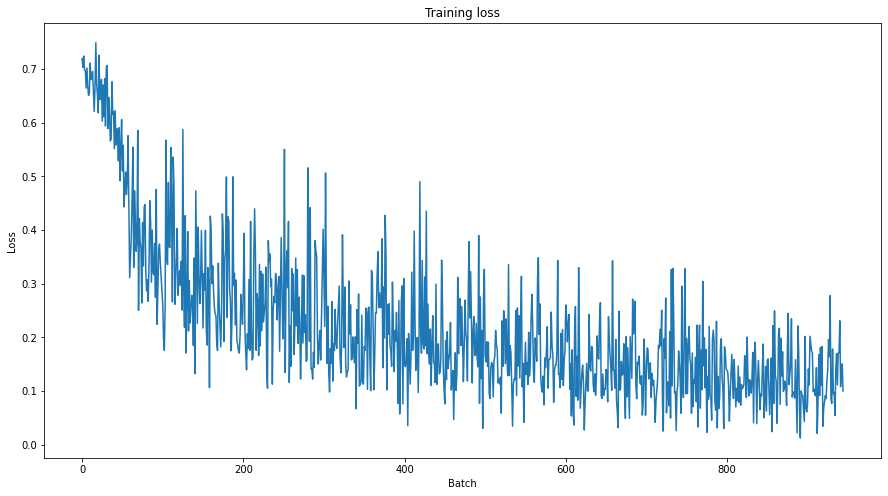

In [28]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [29]:
predictions1_train_flat = [i[1] for a in predictions1_train for i in a]
#predictions2_train_flat = [i[1] for a in predictions2_train for i in a]
#predictions3_train_flat = [i[1] for a in predictions3_train for i in a]

In [141]:
predictions1_train_flat[:3]

[0.0029144746, 0.0012741818, 0.0014574912]

In [30]:
predictions1_train_flat = [1 if i >=0.75 else 0 for i in predictions1_train_flat]
#predictions2_train_flat = [1 if i >=0.75 else 0 for i in predictions2_train_flat]
#predictions3_train_flat = [1 if i >=0.75 else 0 for i in predictions3_train_flat]

In [31]:
true_labels1_train_flat = [i for a in true_labels1_train for i in a]
#true_labels2_train_flat = [i for a in true_labels2_train for i in a]
#true_labels3_train_flat = [i for a in true_labels3_train for i in a]

In [32]:
from sklearn.metrics import precision_recall_fscore_support

def metric_fn(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    return {
        "eval_f1": f1,
        "eval_recall": recall,
        "eval_precision": precision,
    }

In [33]:
recall_train1 = metric_fn(true_labels1_train_flat, predictions1_train_flat)['eval_recall']
precision_train1 = metric_fn(true_labels1_train_flat, predictions1_train_flat)['eval_precision']
f1_train1 = metric_fn(true_labels1_train_flat, predictions1_train_flat)['eval_f1']

#recall_train2 = metric_fn(true_labels2_train_flat, predictions2_train_flat)['eval_recall']
#precision_train2 = metric_fn(true_labels2_train_flat, predictions2_train_flat)['eval_precision']
#f1_train2 = metric_fn(true_labels2_train_flat, predictions2_train_flat)['eval_f1']

#recall_train3 = metric_fn(true_labels3_train_flat, predictions3_train_flat)['eval_recall']
#precision_train3 = metric_fn(true_labels3_train_flat, predictions3_train_flat)['eval_precision']
#f1_train3 = metric_fn(true_labels3_train_flat, predictions3_train_flat)['eval_f1']

In [34]:
print(f"Precision train1: {precision_train1}")
print(f"recall train1: {recall_train1}")
print(f"f1 train1: {f1_train1}")
print("\n")
#print(f"Precision train2: {precision_train2}")
#print(f"recall train2: {recall_train2}")
#print(f"f1 train2: {f1_train2}")
print("\n")
#print(f"Precision train3: {precision_train3}")
#print(f"recall train3: {recall_train3}")
#print(f"f1 train3: {f1_train3}")

Precision train1: 0.8234395460497599
recall train1: 0.8181896255582275
f1 train1: 0.8206332373882745






In [35]:
pred_train1 = pd.DataFrame(predictions1_train_flat, columns = ['Prediction_train1'])
#pred_train2 = pd.DataFrame(predictions2_train_flat, columns = ['Prediction_train2'])
#pred_train3 = pd.DataFrame(predictions3_train_flat, columns = ['Prediction_train3'])

In [36]:
#df_train_pred = pd.concat([df, pred_train1, pred_train2, pred_train3], axis = 1)
df_train_pred = pd.concat([df, pred_train1], axis = 1)
df_train_pred.head()

,short_form,context,long_form,label,sentences,Prediction_train1
0,GPT,bioquímicos en sangre eran normales salvo la G...,glutamic pyruvic transaminar,1,[CLS] glutamic pyruvic transaminar [SEP] bioqu...,0.0
1,GPT,bioquímicos en sangre eran normales salvo la G...,glutamate pyruvatar transaminar,0,[CLS] glutamate pyruvatar transaminar [SEP] bi...,0.0
2,C,"la delgadez ( IMC 17 ) , temperatura 37 º < st...",centimetro,1,[CLS] centimetro [SEP] la delgadez ( IMC 17 ) ...,0.0
3,C,"la delgadez ( IMC 17 ) , temperatura 37 º < st...",centigrado,0,[CLS] centigrado [SEP] la delgadez ( IMC 17 ) ...,0.0
4,C,"la delgadez ( IMC 17 ) , temperatura 37 º < st...",cysteine,0,"[CLS] cysteine [SEP] la delgadez ( IMC 17 ) , ...",0.0


In [37]:
df_train_pred.to_csv("df_train_10_pred_amb_lfnorm_2.csv")

# Prediction

### Preprocessing test dataset

In [38]:
df_test = pd.read_csv("test_data_beto_10_amb_lfnom.csv")

df_test['sentences'] = df_test['long_form'].map(lambda x: "[CLS] " + x + " [SEP] ")+df_test['context'] + ' [SEP]'

# Create sentence and label lists
sentences_test = df_test.sentences.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
# sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels_test = df_test.label.values

tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
# Pad our input tokens
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels_test)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Prediction on test set model 1

In [39]:
# Put model in evaluation mode
model1.eval()

# Tracking variables 
predictions1 , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy= flat_accuracy(logits, label_ids)
    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1
  
  # Store predictions and true labels
  predictions1.append(logits)
  true_labels.append(label_ids)

In [ ]:
predictions1[:2]

In [ ]:
print(len(df_test))
print(len(predictions1))
print(len(true_labels))

### Prediction on test set model 2

In [ ]:
# Put model in evaluation mode
model2.eval()

# Tracking variables 
predictions2 , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    

  # Move logits and labels to CPU
  logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy= flat_accuracy(logits, label_ids)
    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1
  
  # Store predictions and true labels
  predictions2.append(logits)
  true_labels.append(label_ids)

In [ ]:
print(len(predictions2))
print(len(true_labels))

In [ ]:
print(predictions2[:1])

### Prediction on test set model 3

In [ ]:
# Put model in evaluation mode
model3.eval()

# Tracking variables 
predictions3 , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits['logits'].softmax(dim=-1).detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy= flat_accuracy(logits, label_ids)
    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1
  
  # Store predictions and true labels
  predictions3.append(logits)
  true_labels.append(label_ids)

In [ ]:
predictions3[:2]

In [ ]:
print(len(df_test))
print(len(predictions3))
print(len(true_labels))

## Voting Ensemble

In [44]:
predictions1_flat = [i for a in predictions1 for i in a]
#predictions2_flat = [i for a in predictions2 for i in a]
#predictions3_flat = [i for a in predictions3 for i in a]

In [45]:
print(len(predictions1_flat))
predictions1_flat[:3]

1696


[array([0.9741357 , 0.02586428], dtype=float32),
 array([0.66870284, 0.3312972 ], dtype=float32),
 array([0.06737493, 0.93262506], dtype=float32)]

In [ ]:
#average of predictions of both model, as ensemble
predictions_total = []
for a,b in enumerate(zip(predictions1_flat, predictions2_flat, predictions3_flat)):
    predictions_total.append((b[0][1]+b[1][1]+b[2][1])/3)

In [ ]:
len(predictions_total)
type(predictions_total)

In [46]:
true_labels_flat = [i for a in true_labels for i in a]
true_labels_flat[:2]

[1, 0]

Change soft output to hard output to compare with true labels

In [48]:
#predictions_total_binari = [1 if i >=0.75 else 0 for i in predictions_total]
predictions_total_binari = [1 if i[1] >=0.75 else 0 for i in predictions1_flat]

In [ ]:
predictions_total_binari[:5]

# Evaluation

In [49]:
from sklearn.metrics import precision_recall_fscore_support

def metric_fn(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    return {
        "eval_f1": f1,
        "eval_recall": recall,
        "eval_precision": precision,
    }

In [50]:
recall = metric_fn(true_labels_flat, predictions_total_binari)['eval_recall']
precision = metric_fn(true_labels_flat, predictions_total_binari)['eval_precision']
f1 = metric_fn(true_labels_flat, predictions_total_binari)['eval_f1']

In [51]:
print(f"Precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")

Precision: 0.5402152923291836
recall: 0.5273420041119157
f1: 0.49519360858950157


In [52]:

len(predictions_total_binari)

1696

In [ ]:
len(df_test)

In [53]:
pred = pd.DataFrame(predictions_total_binari, columns = ['Prediction'])

In [54]:
df_test_pred = pd.concat([df_test, pred], axis = 1)
df_test_pred.head()

,Unnamed: 0,short_form,context,long_form,label,sentences,Prediction
0,0,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcad...,carbohydrate antiger,1,[CLS] carbohydrate antiger [SEP] IgG 1840 UI/m...,0
1,1,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcad...,california,0,[CLS] california [SEP] IgG 1840 UI/ml ( 751-1....,0
2,2,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcad...,cancer antiger,0,[CLS] cancer antiger [SEP] IgG 1840 UI/ml ( 75...,1
3,3,FA,"UI/ml , GPT 371 UI/ml , GGT 632 UI/ml , < star...",fosfatasa alcalino,1,"[CLS] fosfatasa alcalino [SEP] UI/ml , GPT 371...",1
4,4,FA,"UI/ml , GPT 371 UI/ml , GGT 632 UI/ml , < star...",faceta articular,0,"[CLS] faceta articular [SEP] UI/ml , GPT 371 U...",1


In [56]:
df_test_pred.to_csv("df_test_10_pred_amb_lfnorm_2.csv")

In [ ]:
df_test_pred.iloc[0,5]